In [1]:
import numpy as np
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GroupKFold
from python.utils import write_submission
import matplotlib.pyplot as plt
from python.features_extraction import ExtractFeatures
import os
from tensorflow import keras
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from tensorflow import keras

2021-12-05 13:41:22.653105: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-05 13:41:22.653133: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
fc_parameters = {
    "abs_energy": None,
    "maximum": None,
    "absolute_sum_of_changes": None,
    "fft_coefficient": [{"coeff": 10, "attr": "abs"}],
    "fourier_entropy": [{"bins": 10}],
    "linear_trend": [{"attr": "slope"}],
    "mean": None,
    "number_peaks": [{"n":4}],
    "variance": None,
}

In [2]:
DATA_PATH = 'data'
X_train, y_train, X_test, subjects = load_data(DATA_PATH)

X_train size: (3500, 15872).
y_train size: (3500,).
X_test size: (3500, 15872).


In [5]:
pre_process = Pipeline([
    ("si", SimpleImputer(missing_values=-999999.99, strategy="mean")),
    ("ef", ExtractFeatures(fc_parameters)),
    ("si2", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("scaler", StandardScaler()),
])

In [ ]:


scores = []
histories = []
for train, test in GroupKFold().split(X_train, y_train, subjects):
    # Preprocess each train/test fold
    X_train_pp = pre_process.fit_transform(X_train[train])
    X_test_pp = pre_process.transform(X_train[test])

    # The model
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal", kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal", kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(14, activation="softmax", kernel_initializer="glorot_uniform", kernel_regularizer= keras.regularizers.l2(0.01)))

    # Train the model
    model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
    histories.append(model.fit(X_train_pp, y_train[train]-1, epochs=100, verbose=0, validation_data=(X_test_pp, y_train[test]-1)))
    score = model.evaluate(X_test_pp, y_train[test]-1, verbose=0)[1]
    scores.append(score)

np.mean(scores)

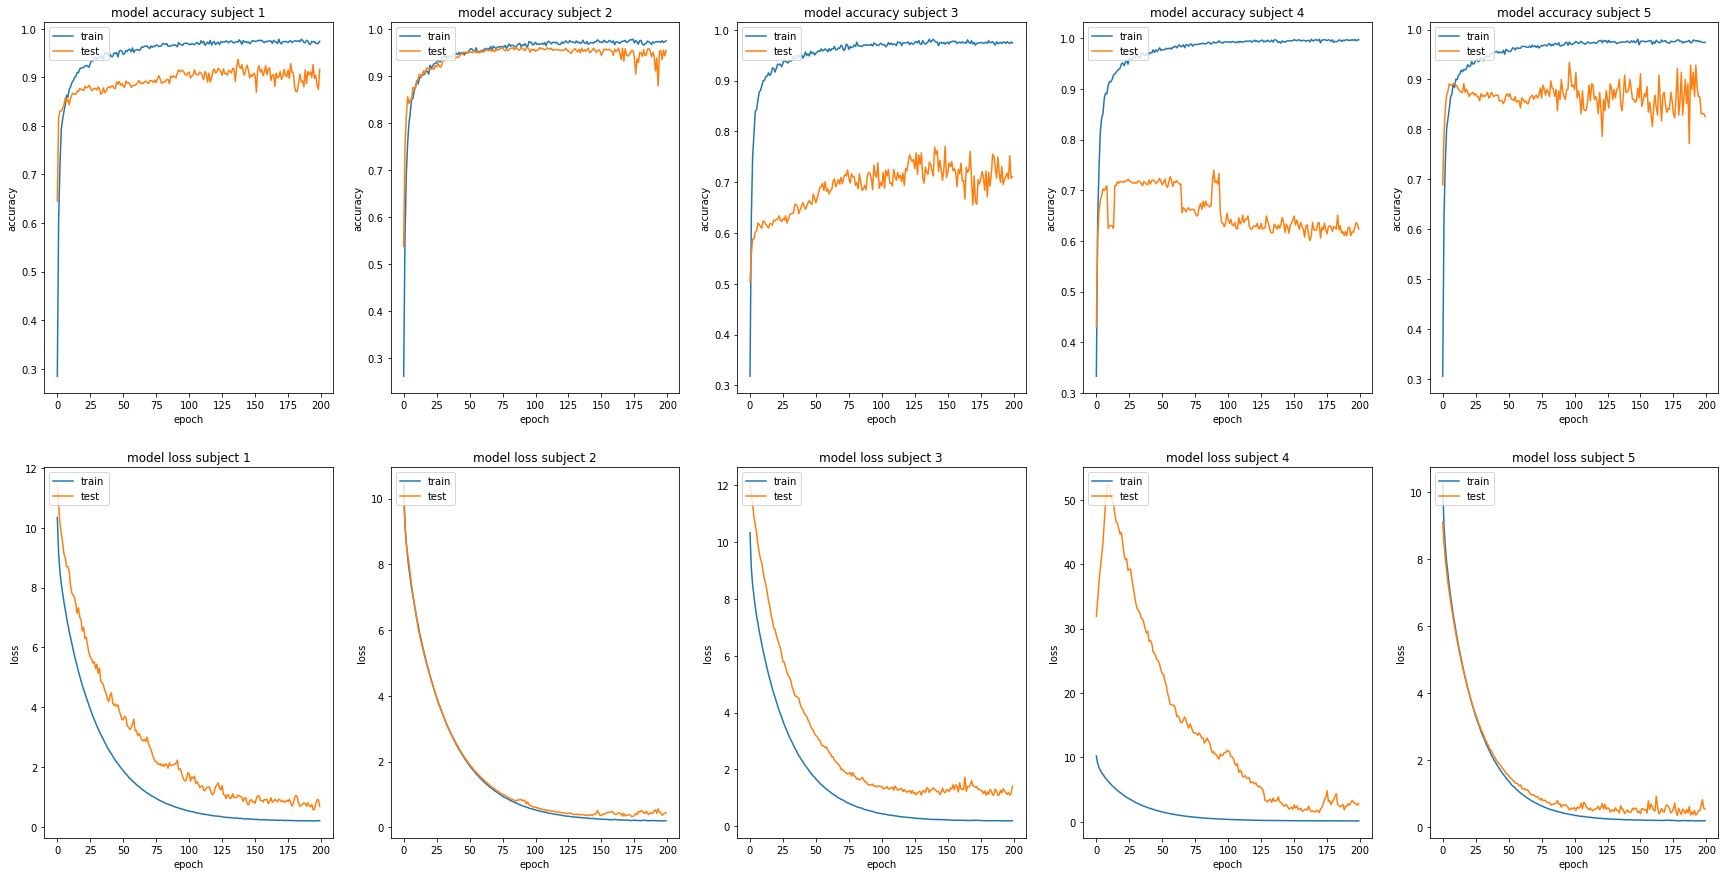

In [13]:
plt.figure(figsize=(30,15))

for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.plot(histories[i].history['accuracy'])
    plt.plot(histories[i].history['val_accuracy'])
    plt.title('model accuracy subject {}'.format(i+1),)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    plt.subplot(2, 5, i+6)
    plt.plot(histories[i].history['loss'])
    plt.plot(histories[i].history['val_loss'])
    plt.title('model loss subject {}'.format(i+1))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
X_train_pp = pre_process.fit_transform(X_train)
X_test_pp = pre_process.transform(X_test)

model = keras.models.Sequential()
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal", kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal", kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(14, activation="softmax", kernel_initializer="glorot_uniform", kernel_regularizer= keras.regularizers.l2(0.01)))

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
model.fit(X_train_pp, y_train-1, epochs=100, verbose=0)

In [ ]:
y_pred = np.argmax(model.predict(X_test_pp), axis=1) + 1

write_submission(y_pred, 'submissions')